# PLACES Health Data

This notebook gathers the [PLACES](https://chronicdata.cdc.gov/500-Cities-Places/PLACES-Place-Data-GIS-Friendly-Format-2021-release/vgc8-iyc4/data) health data from the CDC. This dataset was created initially in November 2016 and was last updated in December 2019 and is collected from the 500 largest cities in the United States. This data is gathered on the census tract level and shows the average of the most common health conditions per tract. 

## Importing the Packages

In [1]:
### Import Libraries

# File manipulation

import os # For working with Operating System
from sys import platform # Diagnose operating system
import urllib # For accessing websites
import zipfile # For extracting from Zipfiles
from io import BytesIO # For reading bytes objects

# Analysis

import numpy as np # For working with Arrays
import pandas as pd # Data Manipulation
import geopandas as gpd # Spatial Data Manipulation

# Visualization

from pprint import pprint # Pretty Printing
import matplotlib.pyplot as plt # Basic Plotting
#import contextily # Base Map Visualization

import warnings
warnings.filterwarnings('ignore') # Ignores some warnings

## Importing the Data

In [2]:
url = ('https://raw.githubusercontent.com/RwHendrickson/MappingGZ/main/Prototype/Notebooks/CleaningData/Health/PLACES_2021.csv')

cdc_health_data = pd.read_csv(url)

cdc_health_data.head()

,StateAbbr,StateDesc,CountyName,CountyFIPS,TractFIPS,TotalPopulation,ACCESS2_CrudePrev,ACCESS2_Crude95CI,ARTHRITIS_CrudePrev,ARTHRITIS_Crude95CI,...,OBESITY_Crude95CI,PHLTH_CrudePrev,PHLTH_Crude95CI,SLEEP_CrudePrev,SLEEP_Crude95CI,STROKE_CrudePrev,STROKE_Crude95CI,TEETHLOST_CrudePrev,TEETHLOST_Crude95CI,Geolocation
0,MN,Minnesota,Anoka,27003,27003050235,2769,10.4,"( 8.6, 12.4)",22.1,"(20.8, 23.2)",...,"(35.6, 38.8)",10.4,"( 9.3, 11.5)",32.5,"(30.8, 34.3)",2.6,"( 2.3, 2.9)",10.3,"( 6.4, 15.0)",POINT (-93.24003196 45.28024905)
1,MN,Minnesota,Carver,27019,27019090401,4545,7.1,"( 5.9, 8.5)",17.7,"(16.9, 18.5)",...,"(26.3, 28.6)",7.5,"( 6.8, 8.3)",25.8,"(24.1, 27.9)",2.0,"( 1.8, 2.1)",5.7,"( 4.1, 7.9)",POINT (-93.71571775 44.84363993)
2,MN,Minnesota,Anoka,27003,27003050217,2724,8.2,"( 6.7, 9.9)",21.5,"(20.2, 22.7)",...,"(33.6, 37.1)",9.3,"( 8.1, 10.3)",31.3,"(29.7, 33.4)",2.3,"( 2.1, 2.6)",6.9,"( 4.3, 10.2)",POINT (-93.30598699 45.28030762)
3,MN,Minnesota,Anoka,27003,27003050114,2803,9.0,"( 7.2, 11.2)",21.2,"(20.0, 22.4)",...,"(33.6, 36.9)",9.2,"( 8.1, 10.4)",30.8,"(29.3, 32.6)",2.3,"( 2.0, 2.6)",7.3,"( 4.3, 10.9)",POINT (-93.36812552 45.33911414)
4,MN,Minnesota,Blue Earth,27013,27013170700,2817,12.4,"( 9.9, 15.6)",14.6,"(13.8, 15.3)",...,"(30.6, 34.7)",10.6,"( 9.5, 11.7)",30.2,"(27.4, 32.7)",2.2,"( 2.0, 2.4)",15.2,"(10.7, 20.8)",POINT (-94.0078327 44.16242874)


## Converting to GDF

In [3]:
crs = 'EPSG:4326' #setting the coordinate system

cdc_health_gdf = gpd.GeoDataFrame(cdc_health_data, crs = crs, geometry = gpd.GeoSeries.from_wkt(cdc_health_data.Geolocation))

cdc_health_gdf.head(2)

,StateAbbr,StateDesc,CountyName,CountyFIPS,TractFIPS,TotalPopulation,ACCESS2_CrudePrev,ACCESS2_Crude95CI,ARTHRITIS_CrudePrev,ARTHRITIS_Crude95CI,...,PHLTH_CrudePrev,PHLTH_Crude95CI,SLEEP_CrudePrev,SLEEP_Crude95CI,STROKE_CrudePrev,STROKE_Crude95CI,TEETHLOST_CrudePrev,TEETHLOST_Crude95CI,Geolocation,geometry
0,MN,Minnesota,Anoka,27003,27003050235,2769,10.4,"( 8.6, 12.4)",22.1,"(20.8, 23.2)",...,10.4,"( 9.3, 11.5)",32.5,"(30.8, 34.3)",2.6,"( 2.3, 2.9)",10.3,"( 6.4, 15.0)",POINT (-93.24003196 45.28024905),POINT (-93.24003 45.28025)
1,MN,Minnesota,Carver,27019,27019090401,4545,7.1,"( 5.9, 8.5)",17.7,"(16.9, 18.5)",...,7.5,"( 6.8, 8.3)",25.8,"(24.1, 27.9)",2.0,"( 1.8, 2.1)",5.7,"( 4.1, 7.9)",POINT (-93.71571775 44.84363993),POINT (-93.71572 44.84364)


## Clipping the Data

In [4]:
def clip_to_extent(cdc):
    '''This function returns the dataset clipped to the boundaries of Minneapolis and the boundary itself.
    Warning: This function will access the geojson of Minneapolis from GitHub if it's not in the current working directory or local Boundary folder.
    See this link for more info: https://github.com/RwHendrickson/MappingGZ/blob/main/Prototype/Notebooks/CleaningData/Boundary/DefineBoundary.ipynb'''
    
    # Look for mpls_boundary
    
    cwd = os.getcwd() # Current working directory

    os.chdir('..') # Bump up one directory

    if 'mpls_boundary.shp' in os.listdir(cwd): # Boundary shapefile in the current working directory
        mpls_boundary = gpd.read_file(r'mpls_boundary.shp') # Load extent as GeoDataFrame

    elif 'mpls_boundary.geojson' in os.listdir(cwd): # Boundary json in the current working directory
        mpls_boundary = gpd.read_file(r'mpls_boundary.geojson') # Load extent as GeoDataFrame

    elif 'Boundary' in os.listdir(): # Boundary folder on computer
        if 'mpls_boundary.geojson' in os.listdir('Boundary'): # Is the json there?
            path = 'Boundary' + slash + 'mpls_boundary.geojson'
            mpls_boundary = gpd.read_file(path)

        else:
            print('''Can't find mpls_boundary.geojson. Accessing from GitHub.\n 
            See this link for more info: \n\nhttps://github.com/RwHendrickson/MappingGZ/blob/main/Prototype/Notebooks/CleaningData/Boundary/DefineBoundary.ipynb''')
            url = 'https://raw.githubusercontent.com/RwHendrickson/MappingGZ/main/Prototype/Notebooks/CleaningData/Boundary/mpls_boundary.geojson'
            mpls_boundary = gpd.read_file(url) # Load extent as GeoDataFrame
    else:
            print('''Can't find mpls_boundary.geojson. Accessing from GitHub.\n 
            See this link for more info: \n\nhttps://github.com/RwHendrickson/MappingGZ/blob/main/Prototype/Notebooks/CleaningData/Boundary/DefineBoundary.ipynb''')
            url = 'https://raw.githubusercontent.com/RwHendrickson/MappingGZ/main/Prototype/Notebooks/CleaningData/Boundary/mpls_boundary.geojson'
            mpls_boundary = gpd.read_file(url) # Load extent as GeoDataFrame


    os.chdir(cwd) # Go back to current working directory
    
    if cdc.crs != 'EPSG:26915': # Ensures gdf is in the same CRS
        cdc = cdc.to_crs('EPSG:26915')
    
    clipped = gpd.clip(cdc, mpls_boundary) # Clip
    
    return clipped, mpls_boundary

In [5]:
cdc_clp, mpls_boundary = clip_to_extent(cdc_health_gdf)

Can't find mpls_boundary.geojson. Accessing from GitHub.
 
            See this link for more info: 

https://github.com/RwHendrickson/MappingGZ/blob/main/Prototype/Notebooks/CleaningData/Boundary/DefineBoundary.ipynb


In [6]:
health = cdc_clp.rename(columns = {'TractFIPS':'GEOID10'})
health.head(2) #checking the clip

,StateAbbr,StateDesc,CountyName,CountyFIPS,GEOID10,TotalPopulation,ACCESS2_CrudePrev,ACCESS2_Crude95CI,ARTHRITIS_CrudePrev,ARTHRITIS_Crude95CI,...,PHLTH_CrudePrev,PHLTH_Crude95CI,SLEEP_CrudePrev,SLEEP_Crude95CI,STROKE_CrudePrev,STROKE_Crude95CI,TEETHLOST_CrudePrev,TEETHLOST_Crude95CI,Geolocation,geometry
1322,MN,Minnesota,Hennepin,27053,27053012102,2819,10.3,"( 8.5, 12.3)",16.9,"(16.1, 17.8)",...,8.8,"( 7.9, 9.9)",27.4,"(26.3, 28.6)",2.3,"( 2.1, 2.6)",6.4,"( 3.8, 10.2)",POINT (-93.21524373 44.89805111),POINT (483005.444 4971647.804)
234,MN,Minnesota,Hennepin,27053,27053011800,4460,7.4,"( 5.9, 9.6)",15.9,"(15.0, 16.8)",...,7.3,"( 6.4, 8.4)",24.7,"(22.8, 26.5)",1.9,"( 1.7, 2.2)",4.3,"( 2.4, 7.6)",POINT (-93.23618668 44.90887201),POINT (481355.393 4972854.447)


In [7]:
cdc_clp.to_file(r'mpls_health_data.shp') # Saving for future use
cdc_clp.to_file(r'mpls_health_data.geojson', driver='GeoJSON')

## Importing Census Tract Boundaries

<AxesSubplot:>

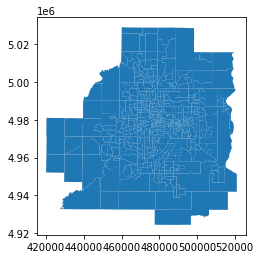

In [8]:
hennepin_tracts = gpd.read_file("Census2010TigerTract.shp")
hennepin_tracts.plot()

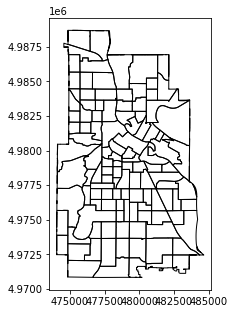

In [9]:
mpls_tracts_clip = gpd.clip(hennepin_tracts, mpls_boundary) #clipping census tract boundaries to mpls
mpls_tracts_clip.plot(figsize=(5,5), edgecolor="black", facecolor="None")
mpls_tracts_clip
mpls_tracts_clip.to_file(r'mpls_census_tracts.shp') #saving as a shapefile for future use

In [10]:
mpls_tracts_clip.head(2)

,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,Shape_Leng,Shape_Area,geometry
359,27,053,023802,27053023802,238.02,Census Tract 238.02,G5020,S,1436930.0,0.0,+44.8971701,-093.3241608,5374.233258,1.435801e+06,"MULTIPOLYGON (((474627.919 4972475.865, 474630..."
492,27,053,111300,27053111300,1113,Census Tract 1113,G5020,S,1776104.0,0.0,+44.9072985,-093.3093354,5646.225669,1.774710e+06,"POLYGON ((475529.871 4972059.890, 475431.109 4..."


## Merging PLACES Data with Census Tracts

In [11]:
health['GEOID10'] = health['GEOID10'].astype(str) #changing the GEOID10 column to a string
mpls_tracts_clip['GEOID10'] = mpls_tracts_clip['GEOID10'].astype(str) #changing the GEOID10 column to a string

# Merge tracts and health, remove final two columns from health, renaming geometry_x to geometry

health_tracts = pd.merge(mpls_tracts_clip, health,
                         left_on = 'GEOID10', right_on = 'GEOID10',
                         how = 'inner').iloc[:,0:81].rename(columns = {'geometry_x':'geometry'})

health_tracts.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 114 entries, 0 to 113
Data columns (total 81 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   STATEFP10               114 non-null    object  
 1   COUNTYFP10              114 non-null    object  
 2   TRACTCE10               114 non-null    object  
 3   GEOID10                 114 non-null    object  
 4   NAME10                  114 non-null    object  
 5   NAMELSAD10              114 non-null    object  
 6   MTFCC10                 114 non-null    object  
 7   FUNCSTAT10              114 non-null    object  
 8   ALAND10                 114 non-null    float64 
 9   AWATER10                114 non-null    float64 
 10  INTPTLAT10              114 non-null    object  
 11  INTPTLON10              114 non-null    object  
 12  Shape_Leng              114 non-null    float64 
 13  Shape_Area              114 non-null    float64 
 14  geometry          

## Creating a Shapefile/GeoJSON of Final Product

In [12]:
health_tracts.to_file(r'mpls_health_tracts.shp') # Save shapefile
health_tracts.to_file(r'mpls_health_tracts.geojson', driver='GeoJSON') # Save GeoJSON